# Vector Quantized Variational Autoencoder (VQVAE) for compression and decompression of images

In [1]:
from keras import layers, Input, Model, Sequential
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.metrics import Mean, MAE
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import glob

In [2]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = beta

        # Initialize the embeddings to quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

    def get_config(self):
        return {
            'num_embeddings': self.num_embeddings,
            'embedding_dim': self.embedding_dim,
            'beta': self.beta
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [4]:
latent_dim = 16
num_embeddings = 64

In [51]:
def get_model_encoder(latent_dim, input_shape):
    block_encoder = Sequential([
    Input(shape=input_shape),
    layers.Conv2D(filters=32, kernel_size=3, activation="relu", strides=2, padding="same"),
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", strides=2, padding="same"),
    layers.Conv2D(latent_dim, 1, padding="same", name=f'le{latent_dim}')],
        name='block_encoder')

    return Model(block_encoder.inputs, block_encoder.outputs, name='model_encoder')


def get_model_decoder(model_encoder_out_shape):
    block_decoder = Sequential([
        Input(shape=model_encoder_out_shape),
        layers.Conv2DTranspose(filters=64, kernel_size=3, activation="relu", strides=2, padding="same"),
        layers.Conv2DTranspose(filters=32, kernel_size=3, activation="relu", strides=2, padding="same"),
        layers.Conv2DTranspose(filters=1, kernel_size=3, padding="same")
    ], name='block_decoder')

    return Model(block_decoder.inputs, block_decoder.outputs, name='model_decoder')

In [31]:
def get_vqvae(shape, latent_dim, num_embeddings, model_encoder, model_decoder):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    inputs = Input(shape=shape)
    encoder_outputs = model_encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = model_decoder(quantized_latents)
    return Model(inputs, reconstructions, name="vq_vae")

In [34]:
class VQVAETrainer(Model):
    def __init__(self, data_shape, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings
        self.model_encoder = get_model_encoder(self.latent_dim, input_shape=data_shape)
        self.model_decoder = get_model_decoder(self.model_encoder.output.shape[1:])

        self.vqvae = get_vqvae(
            shape=data_shape,
            latent_dim=self.latent_dim,
            num_embeddings=self.num_embeddings,
            model_encoder=self.model_encoder,
            model_decoder=self.model_decoder)

        self.total_loss_tracker = Mean(name="total_loss")
        self.reconstruction_loss_tracker = Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance)
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [35]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

data_variance = np.var(x_train / 255.0)

In [36]:
# vqvae_trainer = VQVAETrainer(data_shape=x_train.shape[1:], train_variance=data_variance, latent_dim=16, num_embeddings=128)
vqvae_trainer = VQVAETrainer(data_shape=x_train.shape[1:], train_variance=data_variance, latent_dim=32, num_embeddings=256)

In [45]:
vqvae_trainer.vqvae.summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model_encoder (Functional)  (None, 7, 7, 32)          20896     
                                                                 
 vector_quantizer (VectorQua  (None, 7, 7, 32)         8192      
 ntizer)                                                         
                                                                 
 model_decoder (Functional)  (None, 28, 28, 1)         37249     
                                                                 
Total params: 66,337
Trainable params: 66,337
Non-trainable params: 0
_________________________________________________________________


In [49]:
vqvae_trainer.compile(optimizer=Adam())

history = vqvae_trainer.fit(x_train_scaled,
                            epochs=5,
                            batch_size=128)

Epoch 1/5


2023-07-07 22:30:09.456382: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-07 22:30:09.994008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 14s 21ms/step - loss: 2.4337 - reconstruction_loss: 0.3614 - vqvae_loss: 1.7442
Epoch 2/5
469/469 [==============================] - 9s 20ms/step - loss: 2.7992 - reconstruction_loss: 0.1591 - vqvae_loss: 2.6301
Epoch 3/5
469/469 [==============================] - 9s 20ms/step - loss: 1.1875 - reconstruction_loss: 0.1209 - vqvae_loss: 1.0597
Epoch 4/5
469/469 [==============================] - 10s 20ms/step - loss: 0.7232 - reconstruction_loss: 0.1041 - vqvae_loss: 0.6152
Epoch 5/5
469/469 [==============================] - 10s 21ms/step - loss: 0.5105 - reconstruction_loss: 0.0930 - vqvae_loss: 0.4149


# Evaluation

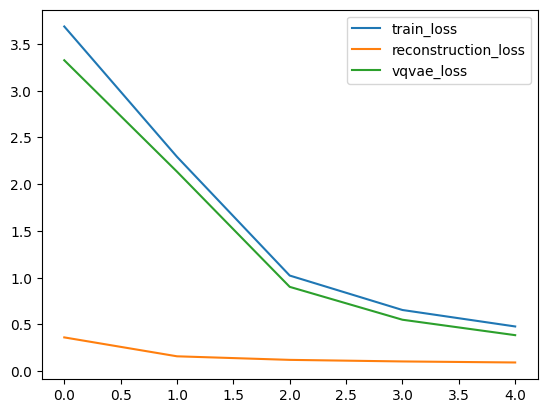

In [50]:
pd.DataFrame({
    'train_loss': history.history["loss"],
    'reconstruction_loss': history.history["reconstruction_loss"],
    'vqvae_loss': history.history["vqvae_loss"]}).plot();

# Store models

In [ ]:
decoder = vqvae_trainer.vqvae.get_layer('decoder')

In [ ]:
version = glob.glob('../models/*').__len__() + 1

file_path = f'../models/lossless_compressor_model_v{version}'
vqvae_trainer.vqvae.save(file_path)

In [ ]:
decoder.save(f'../models/lossless_compressor_decoder_v{version}')

# Load models and layers

In [2]:
vqvae_model = load_model('../models/lossless_compressor_model_v1')

# both decoder_model and vqvae_model.get_layer('decoder') can be used for decompression, remember with the separation of decoder_model will require less memory storage
decoder_model = load_model('../models/lossless_compressor_decoder_v1', compile=False)

Metal device set to: Apple M1 Pro


2023-02-15 15:41:24.241632: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-15 15:41:24.241835: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
encoder = vqvae_model.get_layer("encoder")
quantizer = vqvae_model.get_layer("vector_quantizer")
decoder = vqvae_model.get_layer('decoder')

In [4]:
def get_code_indices(flattened_inputs, embeddings):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

# Test

In [5]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

data_variance = np.var(x_train / 255.0)

In [6]:
idx = np.random.choice(len(x_test_scaled), 10)
test_images = x_test_scaled[idx]

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = get_code_indices(flat_enc_outputs, quantizer.embeddings)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

1/1 [==============================] - 0s 56ms/step


2023-02-15 15:41:41.000851: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-15 15:41:41.029963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [11]:
quantized_latents = quantizer(encoded_outputs)
reconstructed_img = decoder.predict(quantized_latents)

1/1 [==============================] - 0s 11ms/step


(28, 28, 1) (7, 7) (28, 28, 1)


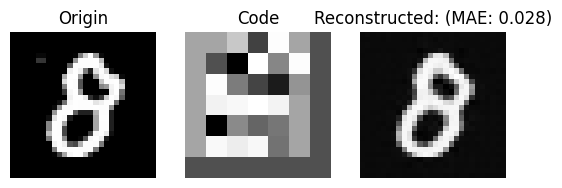

(28, 28, 1) (7, 7) (28, 28, 1)


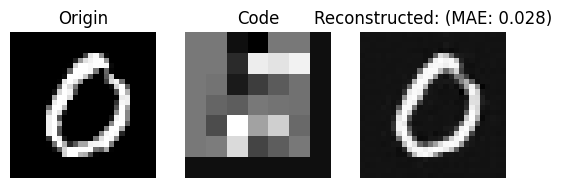

(28, 28, 1) (7, 7) (28, 28, 1)


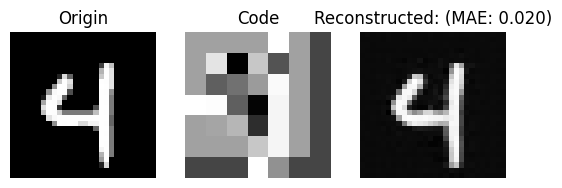

(28, 28, 1) (7, 7) (28, 28, 1)


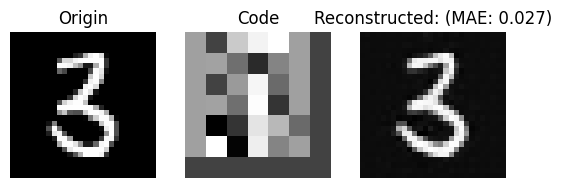

(28, 28, 1) (7, 7) (28, 28, 1)


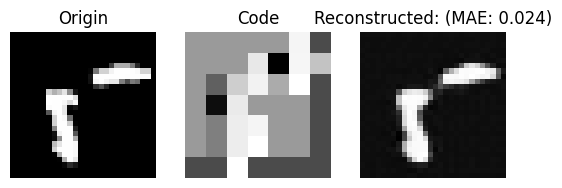

(28, 28, 1) (7, 7) (28, 28, 1)


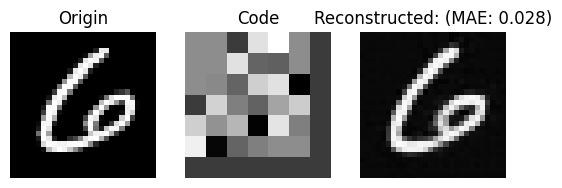

(28, 28, 1) (7, 7) (28, 28, 1)


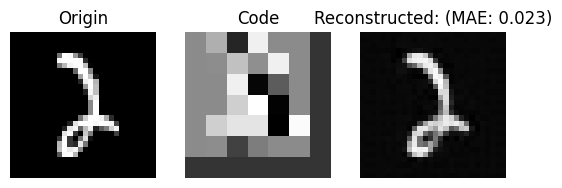

(28, 28, 1) (7, 7) (28, 28, 1)


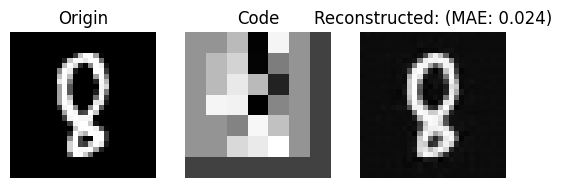

(28, 28, 1) (7, 7) (28, 28, 1)


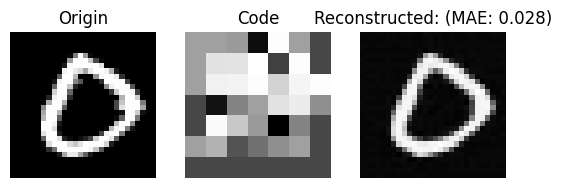

(28, 28, 1) (7, 7) (28, 28, 1)


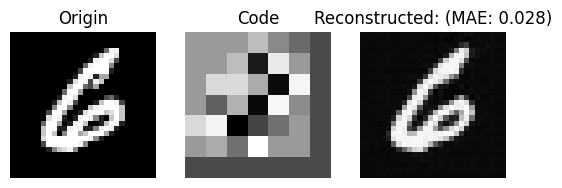

In [10]:
for i in range(len(test_images)):
    plt.subplot(1, 3, 1)
    plt.imshow(test_images[i], cmap="Greys_r")
    plt.title(f"Origin")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(codebook_indices[i], cmap="Greys_r")
    plt.title(f"Code")
    plt.axis("off")

    mean_absolute_error = MAE(test_images[i].flatten(), reconstructed_img[i].flatten())
    mean_absolute_error = np.round(mean_absolute_error.numpy(), 3)

    plt.subplot(1, 3, 3)
    plt.imshow(reconstructed_img[i], cmap="Greys_r")
    plt.title(f"Reconstructed: (MAE: {f'{mean_absolute_error}'[:5]})")

    print(test_images[i].shape, codebook_indices[i].shape, reconstructed_img[i].shape)

    plt.axis("off")
    plt.show()